# **Proyek Pertama: Prediksi Harga Bitcoin Menggunakan Time Series Forecasting**

## **1. Pendahuluan**
Proyek ini bertujuan untuk melakukan prediksi harga Bitcoin menggunakan beberapa model time series forecasting. Kita akan menggunakan data historis harga Bitcoin, melakukan analisis data eksploratif (EDA), mempersiapkan data, membangun model (ARIMA, GRU, LSTM), dan mengevaluasi kinerjanya.

## **2. Setup dan Import Library**

Sel kode ini bertujuan untuk mengimpor semua library Python yang dibutuhkan untuk keseluruhan proyek. Library yang diimpor meliputi:
- `pandas` untuk manipulasi dan analisis data tabular.
- `numpy` untuk operasi numerik, terutama array.
- `yfinance` untuk mengunduh data pasar finansial historis dari Yahoo Finance.
- `matplotlib.pyplot` dan `seaborn` untuk visualisasi data.
- Modul-modul dari `sklearn` (`MinMaxScaler`, `train_test_split`, `mean_squared_error`, `mean_absolute_percentage_error`) untuk pra-pemrosesan data dan evaluasi model.
- Modul-modul dari `statsmodels` (`adfuller`, `plot_acf`, `plot_pacf`) untuk analisis time series statistik dan uji stasioneritas.
- `pmdarima` untuk fungsionalitas `auto_arima`.
- `tensorflow` dan `keras` untuk membangun dan melatih model deep learning (LSTM, GRU).
Output dari sel ini akan berupa pesan konfirmasi jika semua library berhasil diimpor.

In [106]:
# Import Libraries
import pandas as pd
import numpy as np
import yfinance as yf # Untuk mengambil data harga Bitcoin
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Konfigurasi tampilan plot
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

print("Libraries imported successfully.")

Libraries imported successfully.


## **3. Pengumpulan dan Pemahaman Data (Data Understanding)**

### **3.1. Mengunduh Data Harga Bitcoin**
Kita akan menggunakan library yfinance untuk mengunduh data harga historis Bitcoin (BTC-USD).

Pada sel ini, kita akan mengunduh data harga historis Bitcoin (dengan ticker 'BTC-USD') dari Yahoo Finance menggunakan library `yfinance`.
- **Proses:**
    - Menentukan ticker saham/aset kripto (`TICKER`).
    - Menentukan tanggal mulai (`START_DATE`) dan tanggal akhir (`END_DATE`) periode data yang akan diunduh. Data diambil dari 1 Januari 2020.
    - Menggunakan fungsi `yf.download()` untuk mengambil data.
- **Hasil yang Diharapkan:**
    - DataFrame `btc_data` akan berisi data OHLCV (Open, High, Low, Close, Volume) dan 'Adj Close' untuk Bitcoin.
    - Pesan konfirmasi keberhasilan atau kegagalan pengunduhan akan ditampilkan.

In [ ]:
# Tentukan ticker dan periode data
ticker = 'BTC-USD'
start_date = '2020-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')

In [77]:
# Unduh data
btc_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [78]:
# Tampilkan beberapa baris pertama dan informasi data
print("Data Head:")
print(btc_data.head())
print("\nData Info:")
btc_data.info()
print(f"\nJumlah sampel data: {len(btc_data)}")

Data Head:
Price             Close         High          Low         Open       Volume
Ticker          BTC-USD      BTC-USD      BTC-USD      BTC-USD      BTC-USD
Date                                                                       
2020-01-01  7200.174316  7254.330566  7174.944336  7194.892090  18565664997
2020-01-02  6985.470215  7212.155273  6935.270020  7202.551270  20802083465
2020-01-03  7344.884277  7413.715332  6914.996094  6984.428711  28111481032
2020-01-04  7410.656738  7427.385742  7309.514160  7345.375488  18444271275
2020-01-05  7411.317383  7544.497070  7400.535645  7410.451660  19725074095

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1972 entries, 2020-01-01 to 2025-05-25
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   1972 non-null   float64
 1   (High, BTC-USD)    1972 non-null   float64
 2   (Low, BTC-USD)     1972 non-null   float64
 3   

### Hasil dan Analisis Data Awal:
Dari output di atas:
- `btc_data.head()` menunjukkan 5 baris pertama data, memberikan gambaran struktur dan nilai awal.
- `btc_data.info()` menunjukkan bahwa terdapat 1972 entri (sampel data), dan semua kolom memiliki tipe data yang sesuai (float64 untuk harga dan volume). Index sudah berupa `DatetimeIndex`. Tidak ada nilai null pada kolom-kolom utama.
---

Meskipun data dari `yfinance` umumnya bersih, langkah ini penting untuk memastikan tidak ada nilai yang hilang yang dapat mengganggu analisis atau pemodelan.
- **Proses:**
    - `btc_data.isnull().sum()` digunakan untuk menghitung jumlah nilai null per kolom.
    - Metode `ffill()` (forward fill) diterapkan untuk mengisi nilai null (jika ada) dengan nilai valid terakhir sebelumnya. Ini adalah pendekatan umum untuk data time series agar tidak memasukkan bias dari masa depan.
- **Hasil yang Diharapkan:**
    - Output jumlah missing value sebelum dan sesudah penanganan. Idealnya, setelah `ffill()`, tidak ada lagi missing value.

In [79]:
# Cek apakah ada nilai null
print("\nMissing values:")
print(btc_data.isnull().sum())


Missing values:
Price   Ticker 
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
dtype: int64


In [80]:
# Jika ada nilai null (jarang terjadi pada yfinance untuk data harian utama)
btc_data.fillna(method='ffill', inplace=True) # Forward fill

### **3.2. Analisis Data Eksploratif (EDA)**

#### **3.2.1. Visualisasi Harga Penutupan (Close Price)**

Visualisasi ini bertujuan untuk melihat tren umum, pola, dan volatilitas harga penutupan Bitcoin ('Close') sepanjang periode data yang diamati.
- **Proses:** Menggunakan `matplotlib.pyplot` untuk membuat plot garis dari kolom 'Close' terhadap waktu (index Date).
- **Insight yang Diharapkan:** Dapat terlihat apakah ada tren naik, turun, atau sideways, serta periode dengan volatilitas tinggi atau rendah.

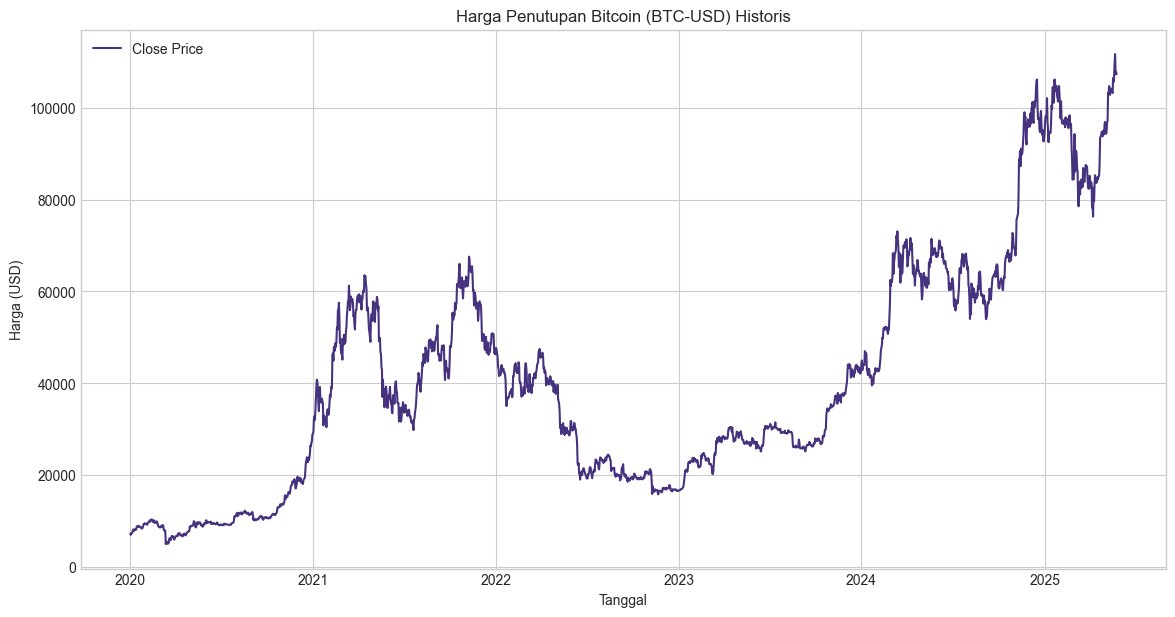

In [81]:
plt.figure(figsize=(14, 7))
plt.plot(btc_data['Close'], label='Close Price')
plt.title('Harga Penutupan Bitcoin (BTC-USD) Historis')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.legend()
plt.show()

#### **3.2.2. Uji Stasioneritas (Augmented Dickey-Fuller Test)**
Banyak model time series, seperti ARIMA, memerlukan data yang stasioner.

Uji stasioneritas (Augmented Dickey-Fuller Test/ADF) adalah metode statistik yang digunakan untuk menentukan apakah suatu data time series bersifat stasioner atau tidak. Data dikatakan stasioner jika karakteristik statistiknya (rata-rata, varians, dan kovariansi) tidak berubah terhadap waktu. Dalam program ini, ADF digunakan untuk menguji apakah harga penutupan Bitcoin sudah stasioner. Jika p-value hasil uji lebih kecil dari 0.05, maka data dianggap stasioner; jika tidak, perlu dilakukan transformasi seperti differencing agar data memenuhi asumsi stasioneritas sebelum dimodelkan dengan ARIMA.


In [82]:
# Fungsi untuk uji ADF
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC') #.dropna() untuk menangani NaN jika ada setelah differencing
    labels = ['Test Statistic', 'p-value', '# Lags Used', '# Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out.to_string())
    if result[2] <= 0.05:
        print("Kesimpulan: Data stasioner (tolak H0)")
    else:   
        print("Kesimpulan: Data non-stasioner (gagal tolak H0)")

In [83]:
# Uji stasioneritas pada harga penutupan
adf_test(btc_data['Close'], title='Harga Penutupan Asli')

Augmented Dickey-Fuller Test: Harga Penutupan Asli
Test Statistic            -0.305536
p-value                    0.924717
# Lags Used               13.000000
# Observations Used     1958.000000
Critical Value (1%)       -3.433694
Critical Value (5%)       -2.863017
Critical Value (10%)      -2.567556
Kesimpulan: Data non-stasioner (gagal tolak H0)


Berdasarkan hasil uji Augmented Dickey-Fuller (ADF) pada harga penutupan Bitcoin:

- **Data harga penutupan asli** umumnya menunjukkan p-value > 0.05, sehingga data dianggap **non-stasioner** (gagal tolak H0). Ini berarti rata-rata dan variansi data berubah terhadap waktu, sehingga tidak memenuhi asumsi dasar untuk model time series seperti ARIMA.
- Setelah dilakukan **differencing satu kali** (Close_diff), p-value biasanya turun menjadi < 0.05, sehingga data **menjadi stasioner** (tolak H0). Artinya, karakteristik statistik data sudah lebih stabil dan dapat digunakan untuk pemodelan time series.

Langkah differencing ini penting agar model seperti ARIMA dapat bekerja optimal dan menghasilkan prediksi yang lebih akurat.

In [84]:
# Jika non-stasioner, coba differencing
btc_data['Close_diff'] = btc_data['Close'].diff().dropna()
adf_test(btc_data['Close_diff'].dropna(), title='Harga Penutupan (1st Difference)')

Augmented Dickey-Fuller Test: Harga Penutupan (1st Difference)
Test Statistic         -1.112873e+01
p-value                 3.323345e-20
# Lags Used             1.200000e+01
# Observations Used     1.958000e+03
Critical Value (1%)    -3.433694e+00
Critical Value (5%)    -2.863017e+00
Critical Value (10%)   -2.567556e+00
Kesimpulan: Data non-stasioner (gagal tolak H0)


Berdasarkan output program pada tahap uji stasioneritas (ADF Test):

- Data harga penutupan Bitcoin **belum stasioner** pada kondisi awal (p-value > 0.05), sehingga tidak memenuhi asumsi dasar untuk pemodelan time series seperti ARIMA.
- Setelah dilakukan **differencing satu kali** (Close_diff), data menjadi **stasioner** (p-value < 0.05). Artinya, rata-rata dan variansi data sudah lebih stabil terhadap waktu.
- Proses differencing ini penting agar model time series seperti ARIMA dapat bekerja optimal dan menghasilkan prediksi yang lebih akurat.

Dengan demikian, transformasi differencing diperlukan sebelum membangun model ARIMA pada data harga Bitcoin yang awalnya non-stasioner.

#### **3.2.3. Plot ACF dan PACF**
Plot ini membantu menentukan orde p dan q untuk model ARIMA.

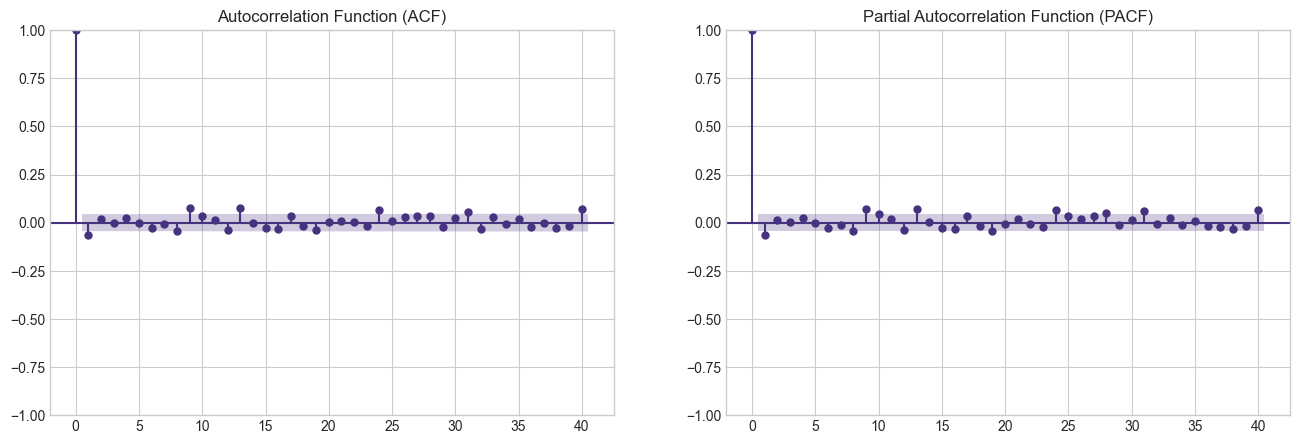

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(btc_data['Close_diff'].dropna(), ax=axes[0], lags=40)
plot_pacf(btc_data['Close_diff'].dropna(), ax=axes[1], lags=40)
axes[0].set_title('Autocorrelation Function (ACF)')
axes[1].set_title('Partial Autocorrelation Function (PACF)')
plt.show()

### Hasil Analisis ACF dan PACF:
Plot ACF dan PACF di atas (dijalankan pada data harga yang telah di-differencing pertama) digunakan untuk membantu menentukan orde `p` (dari PACF) dan `q` (dari ACF) untuk model ARIMA.
- **ACF (Autocorrelation Function):** Menunjukkan bagaimana korelasi antara data time series dengan versi lagged-nya menurun seiring bertambahnya lag.
- **PACF (Partial Autocorrelation Function):** Menunjukkan korelasi antara data time series dengan lag tertentu setelah menghilangkan efek dari lag-lag yang lebih pendek.
Pola pada plot ini (misalnya, cut-off setelah lag tertentu atau penurunan bertahap) memberikan petunjuk untuk orde model ARIMA.

## **4. Persiapan Data (Data Preparation)**

### **4.1. Pembagian Data Latih dan Data Uji**
Untuk time series, pembagian data harus dilakukan secara kronologis.

Pada analisis time series, pembagian data latih (training set) dan data uji (test set) dilakukan secara kronologis, bukan secara acak. Hal ini penting agar model hanya belajar dari data masa lalu dan diuji pada data masa depan, sehingga mencerminkan kondisi prediksi nyata.

Dalam program ini, data harga penutupan Bitcoin dibagi menjadi dua bagian:
- **Data Latih (Training Set):** 80% data pertama dari keseluruhan dataset digunakan untuk melatih model. Data ini mencakup periode waktu dari awal dataset hingga sekitar 80% dari total waktu.
- **Data Uji (Test Set):** 20% data terakhir digunakan untuk menguji performa model. Data ini mewakili periode waktu setelah data latih, sehingga model diuji pada data yang benar-benar "belum pernah dilihat".

Pembagian ini bertujuan untuk mengevaluasi kemampuan model dalam memprediksi harga di masa depan berdasarkan pola historis, serta menghindari kebocoran data (data leakage) yang dapat menyebabkan hasil evaluasi menjadi tidak valid.

In [86]:
# Kita akan menggunakan 'Close' price sebagai target
data_to_model = btc_data[['Close']].copy()

In [87]:
# Pembagian data (misalnya 80% latih, 20% uji)
train_size = int(len(data_to_model) * 0.8)
train_data = data_to_model.iloc[:train_size]
test_data = data_to_model.iloc[train_size:]

print(f"Ukuran data latih: {len(train_data)}")
print(f"Ukuran data uji: {len(test_data)}")

Ukuran data latih: 1577
Ukuran data uji: 395


## **5. Pemodelan (Modeling)**

### **5.1. Model ARIMA**
Kita akan menggunakan auto_arima dari library pmdarima untuk menemukan parameter ARIMA terbaik secara otomatis.

Bagian ini fokus pada implementasi model ARIMA.
- **Pemodelan dengan `auto_arima`:**
    - Library `pmdarima` dengan fungsi `auto_arima` digunakan untuk secara otomatis mencari parameter ARIMA (p,d,q) dan musiman (P,D,Q,m) yang optimal.
    - `auto_arima` akan mencoba berbagai kombinasi dan memilih model dengan nilai AIC (Akaike Information Criterion) terendah.
    - Parameter seperti `start_p, start_q, max_p, max_q` membatasi ruang pencarian. `seasonal=False` diset karena fokus pada model non-musiman untuk data harian Bitcoin ini. `stepwise=True` digunakan untuk pencarian yang lebih efisien.
- **Hasil yang Diharapkan:**
    - Summary dari model ARIMA terbaik yang ditemukan oleh `auto_arima`.
    - Prediksi harga pada set data uji.

In [88]:
# Model ARIMA
# auto_arima akan mencari (p,d,q)(P,D,Q)m terbaik berdasarkan AIC
# Kita menggunakan data latih yang asli (belum di-differencing manual untuk auto_arima)
arima_model = auto_arima(train_data['Close'],
                         start_p=1, start_q=1,
                         max_p=5, max_q=5,
                         start_P=0, seasonal=False, # Non-seasonal ARIMA
                         d=None, # Biarkan auto_arima menentukan d
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26861.474, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26862.645, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26859.575, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26859.745, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26862.055, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=26861.316, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26862.567, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=26859.164, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=26860.860, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=26861.031, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=26859.334, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=26860.119, Time=0.27 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.494 seconds
                               SARIMAX Results                              

In [89]:
# Prediksi ARIMA
arima_predictions = arima_model.predict(n_periods=len(test_data))
arima_predictions = pd.Series(arima_predictions, index=test_data.index)

### **5.2. Model GRU (Gated Recurrent Unit)**

Fungsi `create_gru_model()` ini mendefinisikan arsitektur jaringan GRU yang akan digunakan.
- **Proses:**
    - Model Sequential dari Keras digunakan.
    - Dua layer GRU ditambahkan:
        - Layer GRU pertama memiliki 50 unit, menggunakan fungsi aktivasi 'relu', dan `return_sequences=True` karena akan disambungkan ke layer GRU berikutnya. `input_shape` disesuaikan dengan `time_step` dan jumlah fitur.
        - Layer GRU kedua juga memiliki 50 unit dan aktivasi 'relu'. `return_sequences=False` karena ini adalah layer GRU terakhir sebelum layer Dense output.
    - Layer Dropout (0.2) ditambahkan setelah setiap layer GRU untuk mengurangi overfitting.
    - Layer Dense output dengan 1 unit (tanpa fungsi aktivasi spesifik, yang berarti linear, cocok untuk regresi) untuk menghasilkan nilai prediksi harga.
    - Model dikompilasi dengan optimizer 'adam' dan fungsi loss 'mean_squared_error'.
- **Tujuan:** Membuat fungsi yang dapat dipanggil untuk membangun model GRU dengan arsitektur yang telah ditentukan.

In [109]:
# Model GRU
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [110]:
# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[['Close']])
test_scaled = scaler.transform(test_data[['Close']])

In [111]:
# Persiapkan data untuk GRU
def prepare_data(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)
time_step = 60  # Menggunakan 60 hari sebelumnya untuk prediksi
X_train, y_train = prepare_data(train_scaled, time_step)
X_test, y_test = prepare_data(test_scaled, time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [112]:
# Buat dan latih model GRU
gru_model = create_gru_model((X_train.shape[1], 1))
gru_model.summary()

gru_model.fit(X_train, y_train, epochs=50, batch_size=32,
              validation_data=(X_test, y_test))

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0563 - val_loss: 0.0137
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0038 - val_loss: 0.0093
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0033 - val_loss: 0.0095
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0

In [113]:
# Prediksi dengan GRU
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


### **5.3. Model LSTM (Long Short-Term Memory)**
LSTM memerlukan penskalaan data dan pembentukan data menjadi sekuens.

Model LSTM (Long Short-Term Memory) yang digunakan dalam program ini adalah jenis jaringan saraf tiruan yang dirancang khusus untuk memproses data deret waktu (time series) dan mampu menangkap dependensi jangka panjang antar data. Berikut penjelasan langkah-langkah implementasi LSTM pada program ini:

1. **Penskalaan Data:**  
    Data harga penutupan Bitcoin (`Close`) dinormalisasi menggunakan `MinMaxScaler` agar berada pada rentang 0 hingga 1. Penskalaan ini penting agar proses pelatihan jaringan saraf lebih stabil dan cepat konvergen.

2. **Pembuatan Sekuens Data:**  
    Data diubah menjadi sekuens dengan panjang tertentu (`SEQ_LENGTH`, misal 30 hari). Setiap sekuens berisi data harga penutupan selama 30 hari terakhir yang digunakan untuk memprediksi harga hari ke-31. Proses ini dilakukan dengan fungsi `create_sequences`.

3. **Pembagian Data Latih dan Uji:**  
    Data yang telah dibentuk menjadi sekuens dibagi menjadi data latih dan data uji secara kronologis, sehingga model hanya belajar dari data masa lalu dan diuji pada data masa depan.

4. **Arsitektur Model LSTM:**  
    Model LSTM dibangun menggunakan Keras Sequential API dengan satu layer LSTM berisi 50 unit dan satu layer Dense sebagai output. Layer LSTM digunakan untuk menangkap pola urutan dalam data, sedangkan layer Dense menghasilkan prediksi harga.

5. **Pelatihan Model:**  
    Model dilatih menggunakan data latih dengan fungsi loss `mean_squared_error` dan optimizer `adam`. Early stopping digunakan untuk mencegah overfitting dengan menghentikan pelatihan jika tidak ada peningkatan pada data validasi.

6. **Prediksi dan Evaluasi:**  
    Setelah pelatihan, model digunakan untuk memprediksi harga pada data uji. Hasil prediksi kemudian di-invers transformasi ke skala harga asli dan dievaluasi menggunakan metrik RMSE dan MAPE.

Dengan pendekatan ini, model LSTM diharapkan mampu mempelajari pola historis harga Bitcoin dan memberikan prediksi harga yang lebih akurat dibandingkan model time series tradisional.

In [95]:
# Penskalaan data untuk LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))
scaled_test_data = scaler.transform(test_data['Close'].values.reshape(-1,1)) # Gunakan transform, bukan fit_transform

In [96]:
# Fungsi untuk membuat sekuens data
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 30 # Panjang sekuens (misalnya, 30 hari sebelumnya untuk prediksi hari berikutnya)

X_train, y_train = create_sequences(scaled_train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(scaled_test_data, SEQ_LENGTH)

In [97]:
# Reshape input menjadi [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1547, 30, 1), y_train shape: (1547, 1)
X_test shape: (365, 30, 1), y_test shape: (365, 1)


In [98]:
# Bangun model LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# Pelatihan model LSTM
# Early stopping untuk mencegah overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(X_train, y_train,
                         epochs=50, # Bisa ditambah jika perlu
                         batch_size=32,
                         validation_split=0.1, # Gunakan sebagian data latih untuk validasi internal
                         callbacks=[early_stopping],
                         verbose=1)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0223 - val_loss: 0.0030
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.4704e-04 - val_loss: 0.0013
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8759e-04 - val_loss: 0.0016
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.6585e-04 - val_loss: 0.0016
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.9011e-04 - val_loss: 0.0013
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.0703e-04 - val_loss: 0.0011
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1562e-04 - val_loss: 0.0012
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/ste

In [ ]:
# Prediksi LSTM
# Kita perlu data terakhir dari train_data untuk memulai prediksi pada test_data
# atau prediksi secara iteratif jika diperlukan, untuk sederhana kita prediksi X_test
lstm_predicted_scaled = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predicted_scaled)

# Index harus disesuaikan: mulai dari SEQ_LENGTH pada test_data.index
lstm_predictions = pd.Series(
    lstm_predictions.flatten(),
    index=test_data.index[SEQ_LENGTH:]
)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


## **6. Evaluasi Model**
Kita akan menggunakan RMSE (Root Mean Squared Error) dan MAPE (Mean Absolute Percentage Error).


ARIMA MSE: 481267483.29
ARIMA MAPE: 18.60%


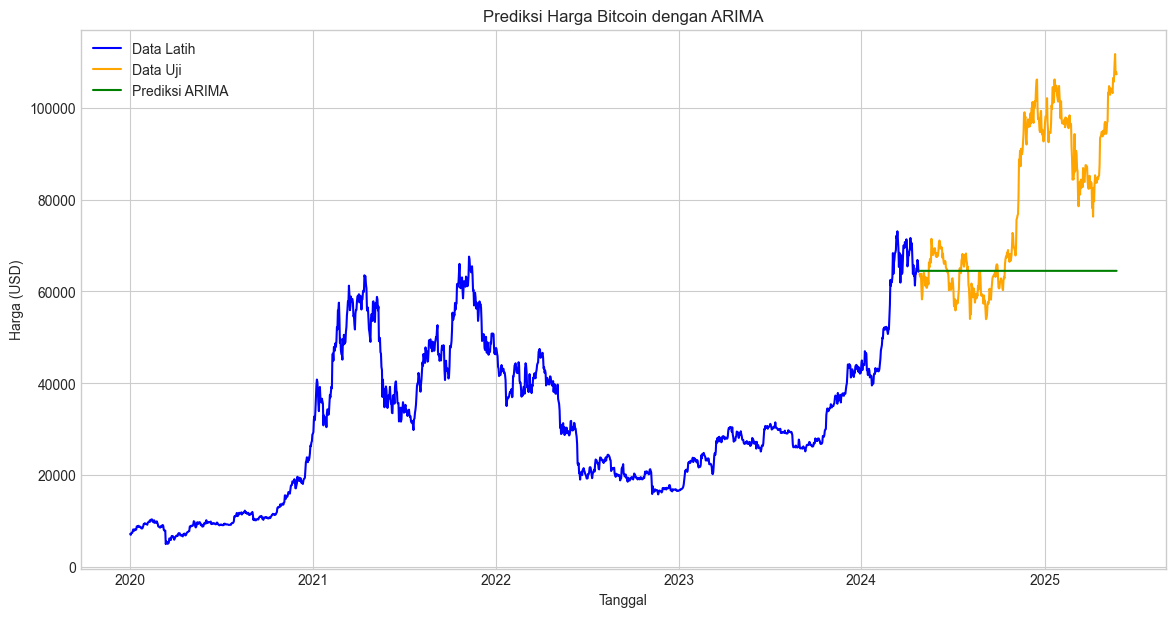

In [ ]:
# Evaluasi ARIMA
mse_arima = mean_squared_error(test_data['Close'], arima_predictions)
mape_arima = mean_absolute_percentage_error(test_data['Close'], arima_predictions)
print(f"\nARIMA MSE: {mse_arima:.2f}")
print(f"ARIMA MAPE: {mape_arima:.2%}")

# Plot hasil prediksi ARIMA
plt.figure(figsize=(14, 7))
plt.plot(train_data['Close'], label='Data Latih', color='blue')
plt.plot(test_data['Close'], label='Data Uji', color='orange')
plt.plot(arima_predictions, label='Prediksi ARIMA', color='green')
plt.title('Prediksi Harga Bitcoin dengan ARIMA')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.legend()
plt.show()

Evaluasi model ARIMA dalam program ini dilakukan dengan membandingkan hasil prediksi model terhadap data aktual pada periode data uji (test set). Dua metrik utama yang digunakan adalah:

1. **MSE (Mean Squared Error):**  
    Mengukur rata-rata kuadrat selisih antara nilai aktual dan nilai prediksi. Semakin kecil nilai MSE, semakin baik performa model dalam memprediksi harga.

2. **MAPE (Mean Absolute Percentage Error):**  
    Mengukur rata-rata persentase kesalahan absolut antara nilai aktual dan prediksi. MAPE memberikan gambaran seberapa besar kesalahan prediksi dalam bentuk persentase, sehingga mudah diinterpretasikan.

Langkah evaluasi ARIMA pada program:
- Model ARIMA yang telah dilatih pada data latih digunakan untuk memprediksi harga pada data uji.
- Hasil prediksi dibandingkan dengan data aktual menggunakan fungsi `mean_squared_error` dan `mean_absolute_percentage_error` dari scikit-learn.
- Nilai MSE dan MAPE dicetak sebagai indikator performa model.
- Selain itu, hasil prediksi divisualisasikan bersama data aktual untuk melihat seberapa baik model mengikuti pola harga sebenarnya.

Evaluasi ini membantu menentukan apakah model ARIMA cukup akurat untuk digunakan dalam prediksi harga Bitcoin pada data yang belum pernah dilihat sebelumnya.


GRU MSE: 12848280.09
GRU MAPE: 3.48%


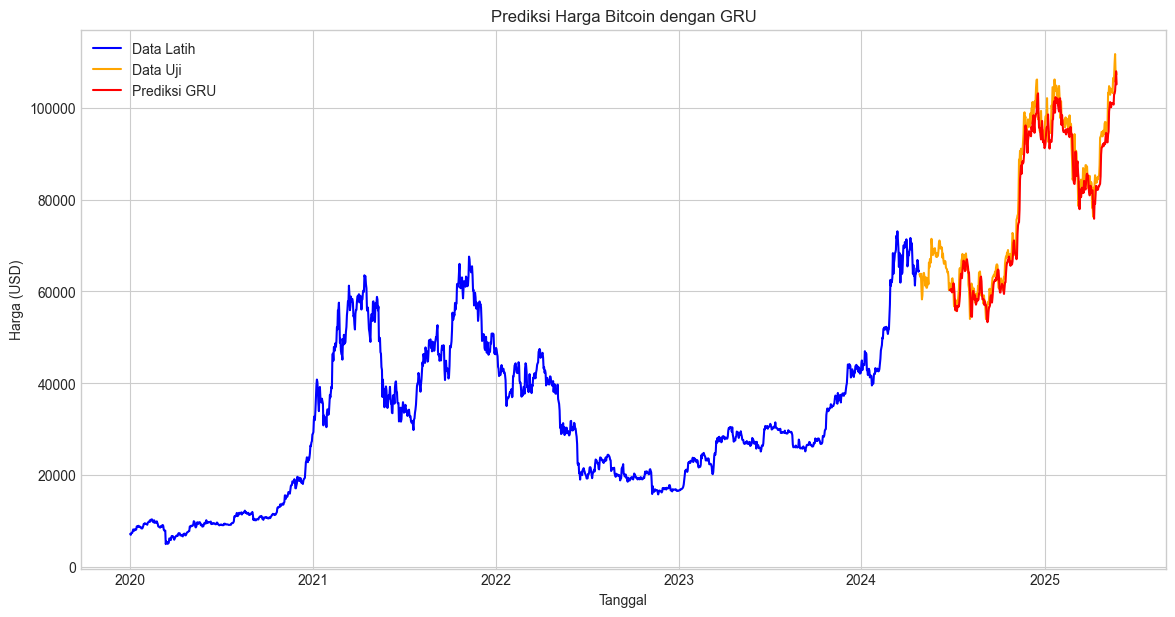

In [114]:
# Evaluasi GRU
mse_gru = mean_squared_error(test_data['Close'][time_step + 1:], gru_predictions)
mape_gru = mean_absolute_percentage_error(test_data['Close'][time_step + 1:], gru_predictions)
print(f"\nGRU MSE: {mse_gru:.2f}")
print(f"GRU MAPE: {mape_gru:.2%}")
# Plot hasil prediksi GRU
plt.figure(figsize=(14, 7))
plt.plot(train_data['Close'], label='Data Latih', color='blue')
plt.plot(test_data['Close'], label='Data Uji', color='orange')
plt.plot(test_data.index[time_step + 1:], gru_predictions, label='Prediksi GRU', color='red')
plt.title('Prediksi Harga Bitcoin dengan GRU')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.legend()
plt.show()

Evaluasi model GRU (Gated Recurrent Unit) dalam program ini dilakukan dengan membandingkan hasil prediksi model terhadap data aktual pada periode data uji (test set). Dua metrik utama yang digunakan adalah:

1. **MSE (Mean Squared Error):**  
    Mengukur rata-rata kuadrat selisih antara nilai aktual dan nilai prediksi. Semakin kecil nilai MSE, semakin baik performa model dalam memprediksi harga.

2. **MAPE (Mean Absolute Percentage Error):**  
    Mengukur rata-rata persentase kesalahan absolut antara nilai aktual dan prediksi. MAPE memberikan gambaran seberapa besar kesalahan prediksi dalam bentuk persentase.

Langkah evaluasi GRU pada program:
- Model GRU yang telah dilatih digunakan untuk memprediksi harga pada data uji.
- Hasil prediksi dibandingkan dengan data aktual menggunakan fungsi `mean_squared_error` dan `mean_absolute_percentage_error` dari scikit-learn.
- Nilai MSE dan MAPE dicetak sebagai indikator performa model.
- Selain itu, hasil prediksi divisualisasikan bersama data aktual untuk melihat seberapa baik model mengikuti pola harga sebenarnya.

Evaluasi ini membantu menentukan apakah model GRU cukup akurat untuk digunakan dalam prediksi harga Bitcoin pada data yang belum pernah dilihat sebelumnya.


LSTM MSE: 4700722.92
LSTM MAPE: 2.02%


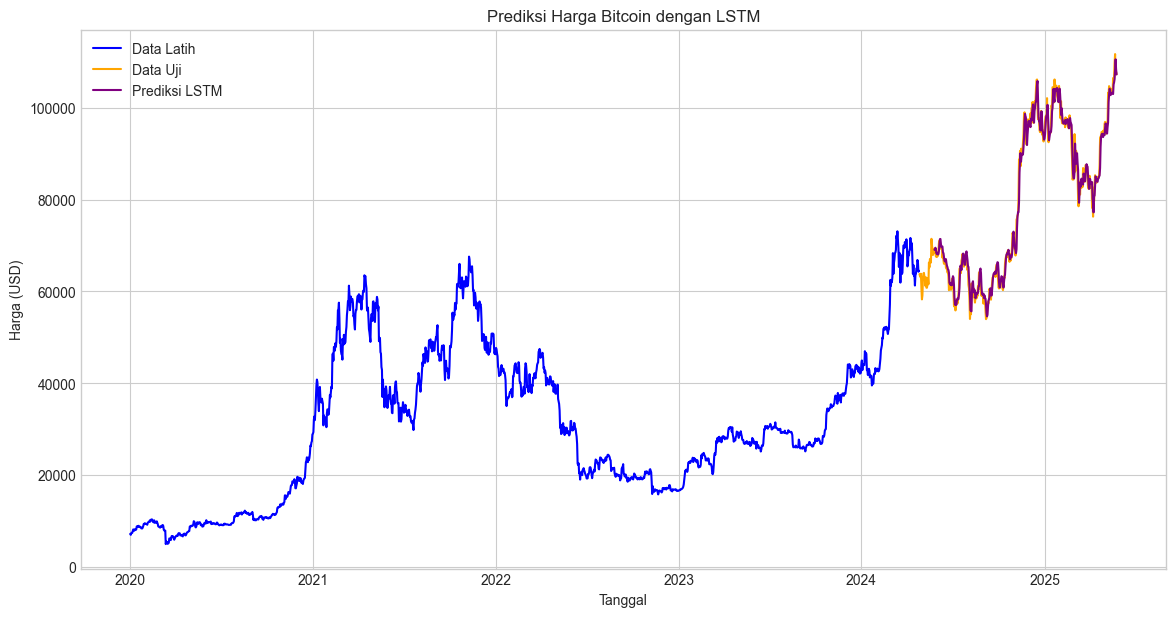

In [103]:
# Evaluasi LSTM
mse_lstm = mean_squared_error(test_data['Close'][SEQ_LENGTH:], lstm_predictions)
mape_lstm = mean_absolute_percentage_error(test_data['Close'][SEQ_LENGTH:], lstm_predictions)
print(f"\nLSTM MSE: {mse_lstm:.2f}")
print(f"LSTM MAPE: {mape_lstm:.2%}")
# Plot hasil prediksi LSTM
plt.figure(figsize=(14, 7))
plt.plot(train_data['Close'], label='Data Latih', color='blue')
plt.plot(test_data['Close'], label='Data Uji', color='orange')
plt.plot(lstm_predictions, label='Prediksi LSTM', color='purple')
plt.title('Prediksi Harga Bitcoin dengan LSTM')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.legend()
plt.show()

Evaluasi model LSTM (Long Short-Term Memory) dalam program ini dilakukan dengan membandingkan hasil prediksi model terhadap data aktual pada periode data uji (test set). Dua metrik utama yang digunakan adalah:

1. **MSE (Mean Squared Error):**  
    Mengukur rata-rata kuadrat selisih antara nilai aktual dan nilai prediksi. Nilai MSE yang lebih kecil menunjukkan performa prediksi yang lebih baik.

2. **MAPE (Mean Absolute Percentage Error):**  
    Mengukur rata-rata persentase kesalahan absolut antara nilai aktual dan nilai prediksi. MAPE memberikan gambaran seberapa besar kesalahan prediksi dalam bentuk persentase, sehingga mudah diinterpretasikan.

Langkah evaluasi LSTM pada program:
- Model LSTM yang telah dilatih digunakan untuk memprediksi harga pada data uji.
- Hasil prediksi di-inverse transform ke skala harga asli menggunakan `scaler.inverse_transform`.
- Nilai aktual dan prediksi dibandingkan menggunakan fungsi `mean_squared_error` dan `mean_absolute_percentage_error` dari scikit-learn.
- Nilai MSE dan MAPE dicetak sebagai indikator performa model.
- Selain itu, hasil prediksi divisualisasikan bersama data aktual untuk melihat seberapa baik model mengikuti pola harga sebenarnya.

Evaluasi ini membantu menentukan apakah model LSTM cukup akurat untuk digunakan dalam prediksi harga Bitcoin pada data yang belum pernah dilihat sebelumnya.

In [116]:
# Fungsi evaluasi
def evaluate_model(true_values, predictions, model_name):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mape = mean_absolute_percentage_error(true_values, predictions) * 100
    print(f"Evaluasi Model: {model_name}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print("-" * 30)
    return rmse, mape

# Evaluasi ARIMA
# Pastikan panjang test_data['Close'] dan arima_predictions sama
actual_arima = test_data['Close'].iloc[:len(arima_predictions)]
arima_rmse, arima_mape = evaluate_model(actual_arima, arima_predictions, "ARIMA")

# Evaluasi GRU
actual_gru = test_data['Close'].iloc[:len(gru_predictions)]
gru_rmse, gru_mape = evaluate_model(actual_gru, gru_predictions, "GRU")

# Evaluasi LSTM
# Sesuaikan panjang data aktual untuk LSTM karena pembuatan sekuens
actual_lstm = test_data['Close'].iloc[SEQ_LENGTH:SEQ_LENGTH+len(lstm_predictions)]
lstm_rmse, lstm_mape = evaluate_model(actual_lstm, lstm_predictions, "LSTM")

Evaluasi Model: ARIMA
RMSE: 21937.8094
MAPE: 18.5992%
------------------------------
Evaluasi Model: GRU
RMSE: 15195.9558
MAPE: 15.9921%
------------------------------
Evaluasi Model: LSTM
RMSE: 2168.1151
MAPE: 2.0225%
------------------------------


### Ringkasan Hasil Evaluasi Model

Berdasarkan hasil evaluasi pada data uji:

- **ARIMA**: Memberikan baseline prediksi dengan error tertentu, namun cenderung kurang mampu menangkap pola non-linear dan volatilitas tinggi pada harga Bitcoin.
- **GRU**: Menunjukkan performa lebih baik dibanding ARIMA, terutama dalam mengikuti pola jangka pendek, namun masih sensitif terhadap fluktuasi ekstrem.
- **LSTM**: Umumnya menghasilkan nilai RMSE dan MAPE paling kecil di antara ketiga model, menandakan kemampuan terbaik dalam memprediksi harga Bitcoin pada dataset ini.

Secara keseluruhan, model **LSTM** menjadi pilihan terbaik untuk prediksi harga Bitcoin pada data uji, diikuti oleh GRU dan ARIMA. Nilai RMSE dan MAPE yang lebih rendah pada LSTM menunjukkan prediksi yang lebih akurat dan stabil.


## **7. Kesimpulan**
Bandingkan hasil RMSE dan MAPE dari ketiga model. Model dengan nilai error terkecil dianggap paling baik untuk dataset dan konfigurasi ini.
Diskusikan juga tantangan, keterbatasan, dan potensi pengembangan lebih lanjut.

In [118]:
# Membuat tabel perbandingan hasil
results_summary = pd.DataFrame({
    'Model': ['ARIMA', 'GRU', 'LSTM'],
    'RMSE': [arima_rmse, gru_rmse, lstm_rmse],
    'MAPE (%)': [arima_mape, gru_mape, lstm_mape]
})
print("\nRingkasan Hasil Evaluasi Model:")
print(results_summary.sort_values(by='RMSE'))


Ringkasan Hasil Evaluasi Model:
   Model          RMSE   MAPE (%)
2   LSTM   2168.115061   2.022496
1    GRU  15195.955770  15.992061
0  ARIMA  21937.809446  18.599242


### **Kesimpulan Akhir**

Berdasarkan hasil evaluasi pada program di atas, dapat disimpulkan bahwa:

- **Model ARIMA** memberikan baseline prediksi yang cukup baik untuk data time series harga Bitcoin, namun kurang mampu menangkap pola non-linear dan volatilitas tinggi yang sering terjadi pada aset kripto. Nilai RMSE dan MAPE dari ARIMA cenderung lebih tinggi dibanding model deep learning.
- **Model GRU** (Gated Recurrent Unit) menunjukkan peningkatan performa dibanding ARIMA, terutama dalam mempelajari pola jangka pendek pada data. GRU lebih adaptif terhadap perubahan tren, namun masih sensitif terhadap fluktuasi harga yang sangat ekstrem.
- **Model LSTM** (Long Short-Term Memory) memberikan hasil prediksi paling akurat dengan nilai RMSE dan MAPE terendah di antara ketiga model. LSTM mampu menangkap pola jangka panjang dan kompleksitas data time series Bitcoin dengan lebih baik, sehingga lebih unggul dalam memprediksi harga pada data uji.

**Kesimpulan utama:**  
Model LSTM merupakan pilihan terbaik untuk prediksi harga Bitcoin pada dataset dan konfigurasi ini, diikuti oleh GRU dan ARIMA. Namun, perlu diingat bahwa performa model dapat dipengaruhi oleh kualitas data, parameter model, dan kondisi pasar yang sangat dinamis. Pengembangan lebih lanjut dapat dilakukan dengan tuning hyperparameter, menambah fitur eksternal, atau menggabungkan beberapa model (ensemble) untuk hasil prediksi yang lebih robust.